In [1]:
from qiskit import QuantumRegister,QuantumCircuit,ClassicalRegister
from qiskit import execute,BasicAer
from qiskit.visualization import plot_histogram

In [2]:
c_eff = [[0,1,2],
         [1,0,3],
         [2,0,3],
         [3,1,2]]

In [3]:
def diffuser(nqubits):
    quc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00...0> (H-gates)
    for qubit in range(nqubits):
        quc.h(qubit)
    #Apply transformation |00...0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        quc.x(qubit)
    # Do multicontrolled-Z gate
    quc.h(nqubits-1)
    quc.mct(list(range(nqubits-1)),nqubits-1)
    quc.h(nqubits-1)
    
    #Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        quc.x(qubit)
    # Apply transformation |11...1> -> |s>
    for qubit in range(nqubits):
        quc.h(qubit)
    
    U_s = quc.to_gate()
    U_s.name = "Diffuser_{}".format(nqubits)
    return U_s

In [4]:
lightsout4 = [[0,1,1,1],[0,0,0,0],[1,1,1,1],[0,1,1,0]]

In [5]:
n = 4
address = QuantumRegister(2,name='addr')
tiles = QuantumRegister(n,name='tiles')
flip = QuantumRegister(n,name='flip')
oracle = QuantumRegister(1,name='oracle')
ancilla = QuantumRegister(n,name='ancilla')
classical = ClassicalRegister(4,name='out')
# qc = QuantumCircuit(address,tiles)
qc = QuantumCircuit(address,tiles,flip,ancilla,oracle,classical)
qc.h(address)
qc.h(flip)
qc.x(oracle)
qc.h(oracle)
qc.barrier()

# qc.draw('mpl')

In [6]:
# At address 0 -> data = 0000
qc.x([address[0],address[1]])
board = lightsout4[0]
for i in range(len(board)):
    if board[i] is 1:
        qc.ccx(address[0],address[1],tiles[i])
qc.x([address[0],address[1]])

# At address 1 -> data = 0111
qc.x(address[1])
board = lightsout4[1]
for i in range(len(board)):
    if board[i] is 1:
        qc.ccx(address[0],address[1],tiles[i])
qc.x(address[1])

# At address 2 ->data = 0110
qc.x(address[0])
board = lightsout4[2]
for i in range(len(board)):
    if board[i] is 1:
        qc.ccx(address[0],address[1],tiles[i])
qc.x(address[0])

# At address 3 -> data = 1111
board = lightsout4[3]
for i in range(len(board)):
    if board[i] is 1:
        qc.ccx(address[0],address[1],tiles[i])
# qc.draw('mpl')

In [7]:
for ce in c_eff:
    qc.cx(flip[ce],tiles[ce[0]])

qc.x(tiles)
qc.mct(tiles,oracle,ancilla,mode='basic')
qc.x(tiles)

for ce in c_eff:
    qc.cx(flip[ce],tiles[ce[0]])

qc.append(diffuser(n),flip)

for i in range(len(flip)):
    qc.mct([flip[i],ancilla[0],ancilla[1],ancilla[2]],ancilla[3],mode='noancilla')
    qc.mct([flip[i],ancilla[0],ancilla[1]],ancilla[2],mode='noancilla')
    qc.ccx(flip[i],ancilla[0],ancilla[1])
    qc.cx(flip[i],ancilla[0])

# marking the solutions which require  < 2 pushes
qc.x([ancilla[2],ancilla[1],ancilla[3]])
qc.mct(ancilla[1:],oracle,mode='noancilla')
qc.x([ancilla[2],ancilla[1],ancilla[3]])


for i in range(len(flip)):
    qc.cx(flip[n-1-i],ancilla[0])
    qc.ccx(flip[n-1-i],ancilla[0],ancilla[1])
    qc.mct([flip[n-1-i],ancilla[0],ancilla[1]],ancilla[2],mode='noancilla')
    qc.mct([flip[n-1-i],ancilla[0],ancilla[1],ancilla[2]],ancilla[3],mode='noancilla')

qc.append(diffuser(n),flip)
for ce in c_eff:
    qc.cx(flip[ce],tiles[ce[0]])

qc.x(tiles)
qc.mct(tiles,oracle,ancilla,mode='basic')
qc.x(tiles)

for ce in c_eff:
    qc.cx(flip[ce],tiles[ce[0]])

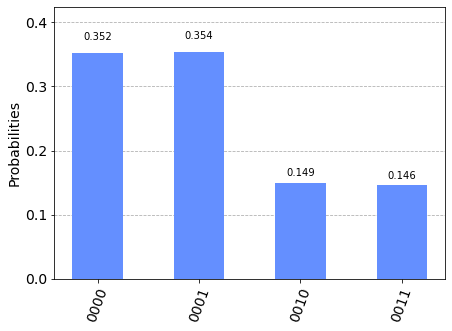

In [8]:
# At address 0 -> data = 0000
qc.x([address[0],address[1]])
board = lightsout4[0]
for i in range(len(board)):
    if board[i] is 1:
        qc.ccx(address[0],address[1],tiles[i])
qc.x([address[0],address[1]])

# At address 1 -> data = 0111
qc.x(address[1])
board = lightsout4[1]
for i in range(len(board)):
    if board[i] is 1:
        qc.ccx(address[0],address[1],tiles[i])
qc.x(address[1])

# At address 2 ->data = 0110
qc.x(address[0])
board = lightsout4[2]
for i in range(len(board)):
    if board[i] is 1:
        qc.ccx(address[0],address[1],tiles[i])
qc.x(address[0])

# At address 3 -> data = 1111
board = lightsout4[3]
for i in range(len(board)):
    if board[i] is 1:
        qc.ccx(address[0],address[1],tiles[i])
# qc.draw('mpl')

qc.append(diffuser(2),address)
qc.measure(address,classical[0:2])
plot_histogram(execute(qc,backend=BasicAer.get_backend('qasm_simulator')).result().get_counts())